## Load the data

In [19]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt

In [20]:
data = np.load("/Users/bogdancristianmihaila/Desktop/3rd Semester/ML-project/data/fashion_train.npy")
X = data[:, :-1]  # All rows, first 784 columns
y = data[:, -1]   # All rows, last column
print(X.shape)
print(y.shape)

(10000, 784)
(10000,)


In [ ]:
def lda(X, y, num_components):
    """
    LDA: Linear Discriminant Analysis
    :param X: ndarray, shape (num_samples, num_features)
        Training data, where num_samples in the number of samples
        and num_features is the number of features.
    :param y: ndarray, shape (num_samples,)
        Target values.
    :param num_components: int
        Number of components to keep.
    :return: ndarray, shape (num_features, num_components)
        Transformed matrix W.
    """

    # Step 1: Compute the mean vectors for each class
    class_labels = np.unique(y)
    mean_vectors = []
    for cl in class_labels:
        mean_vectors.append(np.mean(X[y == cl], axis=0))
    mean_overall = np.mean(X, axis=0)

    # Step 2: Compute the within-class scatter matrix
    S_W = np.zeros((X.shape[1], X.shape[1]))
    for cl, mv in zip(class_labels, mean_vectors):
        class_sc_mat = np.zeros((X.shape[1], X.shape[1]))  # scatter matrix for every class
        for row in X[y == cl]:
            row, mv = row.reshape(X.shape[1], 1), mv.reshape(X.shape[1], 1)  # make column vectors
            class_sc_mat += (row - mv).dot((row - mv).T)
        S_W += class_sc_mat  # sum class scatter matrices

    # Step 3: Compute the between-class scatter matrix
    S_B = np.zeros((X.shape[1], X.shape[1]))
    for i, mean_vec in enumerate(mean_vectors):  
        n = X[y == class_labels[i], :].shape[0]
        mean_vec = mean_vec.reshape(X.shape[1], 1)  # make column vector
        mean_overall = mean_overall.reshape(X.shape[1], 1)  # make column vector
        S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

    # Step 4: Compute the eigenvectors and eigenvalues
    eig_vals, eig_vecs = eig(np.linalg.inv(S_W).dot(S_B))

    # Step 5: Sort the eigenvectors by decreasing eigenvalues
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

    # Step 6: Choose k eigenvectors with the largest eigenvalues
    W = np.hstack([eig_pairs[i][1].reshape(X.shape[1], 1) for i in range(num_components)])

    return W

# Example usage (assuming you have X as your data and y as labels)
W = lda(X, y, num_components=2)
X_lda = X.dot(W) # Transforming the data



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


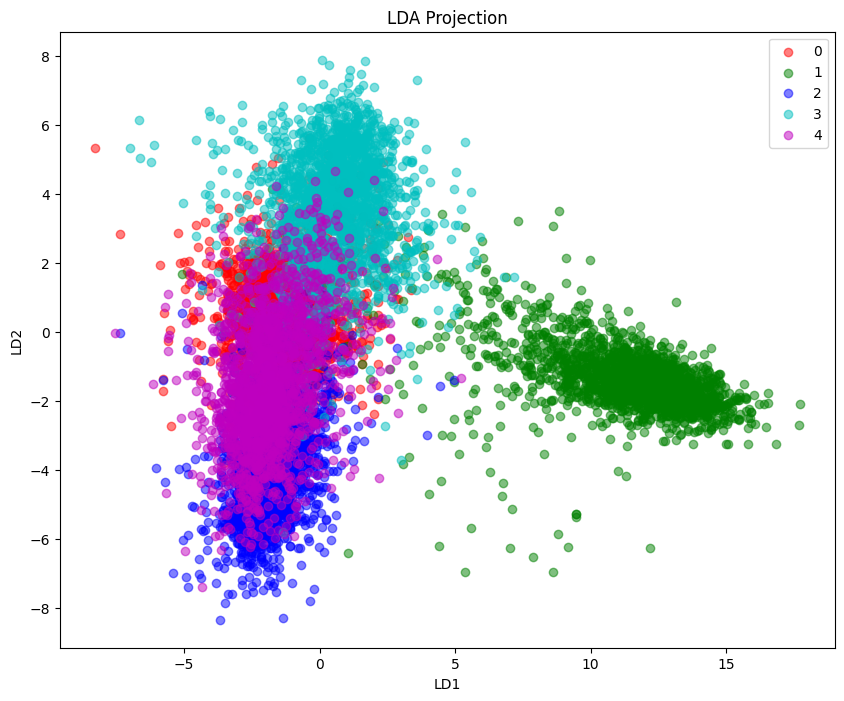

In [21]:
import numpy as np
import scipy.linalg as la

class LDA_AJP:
    def __init__(self, X, y):
        """
        Initializes the LDA class with data and class labels.
        
        Parameters:
        - X: numpy array of shape (n_samples, n_features)
        - y: numpy array of shape (n_samples,) representing class labels
        """
        self._validate_input(X, y)
        self.X = X
        self.y = y
        self.class_means = self._compute_class_means()
        self.central_point = self._compute_central_point()

    def _validate_input(self, X, y):
        """
        Validates the input data and labels.
        Ensures X is a 2D array and y is a 1D array of the same length.
        """
        if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
            raise TypeError("X and y must be numpy arrays.")
        if X.ndim != 2:
            raise ValueError("X must be a 2D array.")
        if y.ndim != 1:
            raise ValueError("y must be a 1D array.")
        if X.shape[0] != y.shape[0]:
            raise ValueError("The number of samples in X and y must be the same.")

    def _compute_class_means(self):
        """
        Computes the mean of each class in the dataset.
        """
        return np.array([np.mean(self.X[self.y == class_label], axis=0) for class_label in np.unique(self.y)])

    def _compute_central_point(self):
        """
        Computes the central point (mean of class means) of the dataset.
        """
        return np.mean(self.class_means, axis=0)

    def _compute_scatter_within(self):
        """
        Computes the within-class scatter matrix.
        """
        return sum([np.cov(self.X[self.y == class_label].T, bias=True) * np.sum(self.y == class_label)
                    for class_label in np.unique(self.y)])

    def _compute_scatter_between(self):
        """
        Computes the between-class scatter matrix.
        """
        return sum([np.sum(self.y == class_label) * np.outer(self.class_means[class_label] - self.central_point,
                                                             self.class_means[class_label] - self.central_point)
                    for class_label in np.unique(self.y)])

    def _compute_lda_matrix(self):
        """
        Computes the LDA matrix by combining the within and between class scatter matrices.
        """
        s_w = self._compute_scatter_within()
        s_b = self._compute_scatter_between()
        s_w_inv = la.pinv(s_w)
        return np.dot(s_w_inv, s_b)

    def compute_linear_discriminants(self):
        """
        Computes the linear discriminants (eigenvalues and eigenvectors) of the LDA matrix.
        """
        lda_matrix = self._compute_lda_matrix()
        eigvals, eigvects = la.eig(lda_matrix)
        idx = eigvals.argsort()[::-1]
        return eigvals[idx], eigvects[:, idx]

    def project_data(self, n_discriminants=2):
        """
        Projects the data onto the specified number of top linear discriminants.
        
        Parameters:
        - n_discriminants: number of top linear discriminants to project onto
        """
        if n_discriminants > len(np.unique(self.y)) - 1:
            raise ValueError("n_discriminants cannot be greater than the number of classes minus one.")
        eigenvals, eigenvects = self.compute_linear_discriminants()
        return np.dot(eigenvects[:, :n_discriminants].T, self.X.T).T

    def main_linear_discriminants(self, n_discriminants=2):
        """
        Extracts the specified number of main linear discriminants (eigenvectors).
        
        Parameters:
        - n_discriminants: number of top linear discriminants to return
        """
        _, eigenvects = self.compute_linear_discriminants()
        return eigenvects[:, :n_discriminants]


# Initialize the LDA object
lda = LDA_AJP(X, y)

# Project the data onto the first 2 linear discriminants
X_lda = lda.project_data(n_discriminants=2)

# Now, let's plot the results
def plot_lda_projection(X_lda, y, title='LDA Projection', xlabel='LD1', ylabel='LD2'):
    plt.figure(figsize=(10, 8))
    unique_classes = np.unique(y)
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange']  # Add more colors if needed
    
    for i, label in enumerate(unique_classes):
        plt.scatter(X_lda[y == label, 0], X_lda[y == label, 1], alpha=0.5, color=colors[i % len(colors)], label=label)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot the LDA projection
plot_lda_projection(X_lda, y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


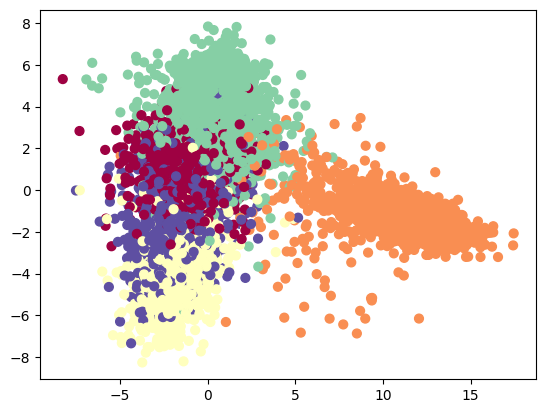

In [7]:
import numpy as np
from scipy.linalg import eig

class LDA:
    def __init__(self, num_components):
        self.num_components = num_components
        self.eigenvectors = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Compute the mean vectors for each class
        mean_vectors = [np.mean(X[y == cl], axis=0) for cl in class_labels]
        mean_overall = np.mean(X, axis=0)

        # Compute within-class scatter matrix
        S_W = np.zeros((n_features, n_features))
        for cl, mean_vec in zip(class_labels, mean_vectors):
            class_sc_mat = np.cov(X[y == cl].T)
            S_W += class_sc_mat

        # Compute between-class scatter matrix
        S_B = np.zeros((n_features, n_features))
        for mean_vec in mean_vectors:  
            n = X[y == cl].shape[0]
            mean_vec = mean_vec.reshape(n_features, 1)
            mean_overall = mean_overall.reshape(n_features, 1)
            S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

        # Solve the eigenvalue problem
        A = np.linalg.inv(S_W).dot(S_B)
        eigenvalues, eigenvectors = eig(A)

        # Sort eigenvectors by eigenvalues in decreasing order
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # Store first n eigenvectors
        self.eigenvectors = eigenvectors[0:self.num_components].T

    def transform(self, X):
        # Projecting the data onto new subspace
        return np.dot(X, self.eigenvectors)

# Example usage:
lda = LDA(num_components=2)
lda.fit(X, y)
X_lda = lda.transform(X)

# plot the scatter plot of LDA
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


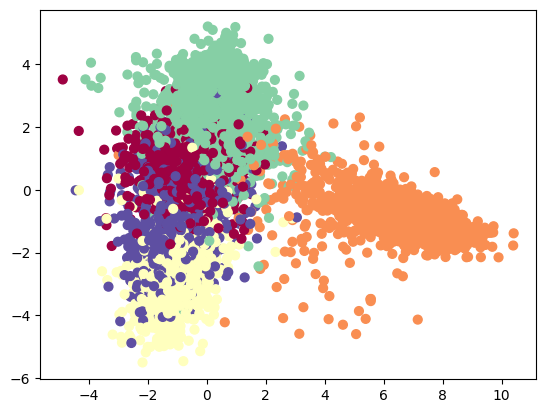

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Implement LDA
lda = LinearDiscriminantAnalysis(n_components=2, solver='eigen')
lda.fit(X, y)
X_lda = lda.transform(X)

#plot the scatter plot of LDA
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()